# Train without normalize
# Train with datasets: KuHar
# Test with dataset: KuHar

1. Apply DFT over dataset windows and universal UMAP
2. Train three times with RF, SVM and KNN, and take the average accuracy and f1-score

# Crossvalidation experiments with KuHar as base and KuHar as target

This notebook will perform crossvalidation experiments using the KuHar dataset at 20 Hz as training dataset. It will contain the following steps:

1. Quick load train, test and validation CSV subsets from the balanced KuHar dataset at 20 Hz using `PandasDatasetsIO` helper
2. Quick load train, test and validation CSV subsets from other relevant datasets using `PandasDatasetsIO` helper
3. Subclassing the `Dataset` interface using `PandasMultiModalDataset`
4. Apply the fourier transform on Charm
5. Apply UMAP
6. Train SVM, KNN and Random Forest classification models on the KuHar dataset in the frequency domain with dimensionality reduction
7. Evaluate SVM, KNN and Random Forest classification models on KuHar in the frequency domain with dimensionality reduction

The experiments will evaluate the performance of SVM, KNN and RF models trained on a balanced KuHar dataset and tested on KuHar in the frequency domain with dimensionality reduction.

In [88]:
from pathlib import Path  # For defining dataset Paths
import sys
sys.path.append("../../../..")

In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from umap import UMAP
#from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

# Librep imports
from librep.utils.dataset import PandasDatasetsIO          # For quick load train, test and validation CSVs
from librep.datasets.har.loaders import KuHarResampledView20HZ

from librep.datasets.multimodal import PandasMultiModalDataset, TransformMultiModalDataset, WindowedTransform
from librep.transforms.fft import FFT
from librep.utils.workflow import SimpleTrainEvalWorkflow, MultiRunWorkflow
from librep.estimators import RandomForestClassifier, SVC, KNeighborsClassifier
from librep.metrics.report import ClassificationReport
from librep.transforms.resampler import SimpleResampler

# Datasets to train the manifold

## Load KuHar

In [90]:
# Path for KuHar resampled to 20Hz view with the same activities (and labels numbers)
# It is assumed that the directory will contain (train.csv, test.csv and validation.csv)
#dataset_path = Path("../../../../data/views/KuHar/resampled_view_20Hz")
loader = KuHarResampledView20HZ("../../../../data/views/KuHar/resampled_view_20Hz", download=False)
train_val_kh, test_kh = loader.load(concat_train_validation=True)

In [91]:
columns = list(train_val_kh.data.iloc[:,:-2].columns)
train_val_kh.window_names

['accel-x', 'accel-y', 'accel-z', 'gyro-x', 'gyro-y', 'gyro-z']

In [92]:
train_val_kh.data.iloc[:,-1]

0        1
1        1
2        1
3        1
4        1
        ..
3433    17
3434    17
3435    17
3436    17
3437    17
Name: normalized activity code, Length: 3438, dtype: int64

In [93]:
# Train Set
kuhar_train_X = np.array(train_val_kh.data.iloc[:,:-10])
kuhar_train_Y = np.array(train_val_kh.data.iloc[:,-1])
tam = len(kuhar_train_Y)
kuhar_train_id_dataset = np.array(['K']*tam)

In [95]:
# Test Set
kuhar_test_X = np.array(test_kh.data.iloc[:,:-10])
kuhar_test_Y = np.array(test_kh.data.iloc[:,-1])
tam = len(kuhar_test_Y)
kuhar_test_id_dataset = np.array(['K']*tam)

## Prepare train and test datas

In [96]:
train_X = np.concatenate([kuhar_train_X])
train_Y = np.concatenate([kuhar_train_Y])
train_id_dataset = np.concatenate([kuhar_train_id_dataset])

test_X = np.concatenate([kuhar_test_X])
test_Y = np.concatenate([kuhar_test_Y])
test_id_dataset = np.concatenate([kuhar_test_id_dataset])

In [97]:
# Train set to classifiers
train = pd.DataFrame(train_X, columns=columns[:-8])
train['normalized activity code'] = train_Y
train['Id Dataset'] = train_id_dataset

# Test set to classifiers
test = pd.DataFrame(test_X, columns=columns[:-8])
test['normalized activity code'] = test_Y
test['Id Dataset'] = test_id_dataset

## Train UMAP

In [102]:
fft_transform = FFT()

# Compose the transform
# First apply the normalizer over whole dataset and then apply FFT over each window
transformer = TransformMultiModalDataset(
    transforms=[#scaler_transform,
                fft_transform], new_window_name_prefix="no-scaling."
)

# Transform it and generate a new dataset!
train_fft = transformer(train_val_kh)
test_fft = transformer(test_kh)

umap = UMAP(n_components=10, random_state=42)
umap.fit(train_val_kh[:][0])

UMAP(n_components=10, random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [114]:
train_fft_umap = umap.transform(train_fft[:][0])
test_fft_umap = umap.transform(test_fft[:][0])

# Datasets to evaluate the manifold

In [124]:
# Train set to classifiers
train = pd.DataFrame(train_fft_umap)
train['normalized activity code'] = train_fft.y

# Test set to classifiers
test = pd.DataFrame(test_fft_umap)
test['normalized activity code'] = test_fft.y

In [125]:
# Creating the datasets

# Train
train = PandasMultiModalDataset(
    train,
    label_columns="normalized activity code",
    as_array=True
)

# Test
test = PandasMultiModalDataset(
    test,
    label_columns="normalized activity code",
    as_array=True
)

# Evaluate the manifold

## Classification

Let's take the transformed datasets and train using RandomForest, SVM and KNN 3 times each. Then take the average accuracy and f1-score over the runs

In [128]:
# The reporter will be the same

reporter = ClassificationReport(
    use_accuracy=True,
    use_f1_score=True,
    use_classification_report=True,
    use_confusion_matrix=True,
    plot_confusion_matrix=True,
    # normalize='true'
)

### RandomForest

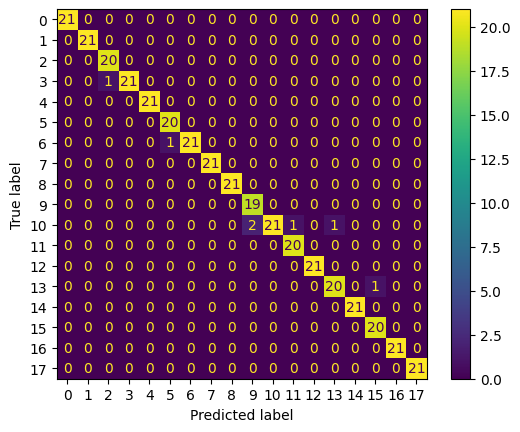

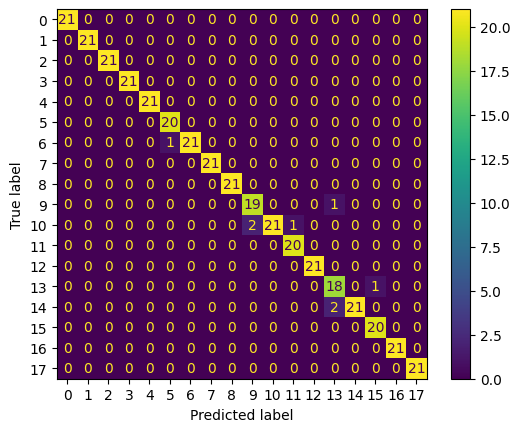

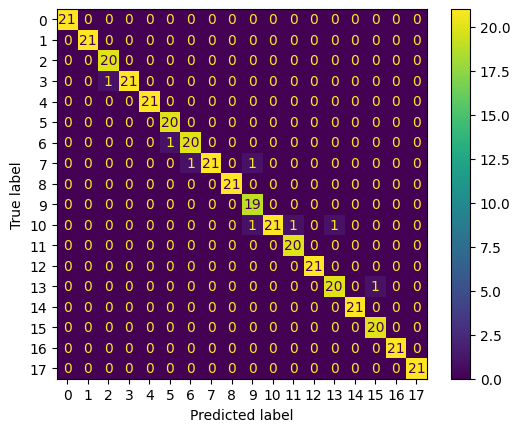

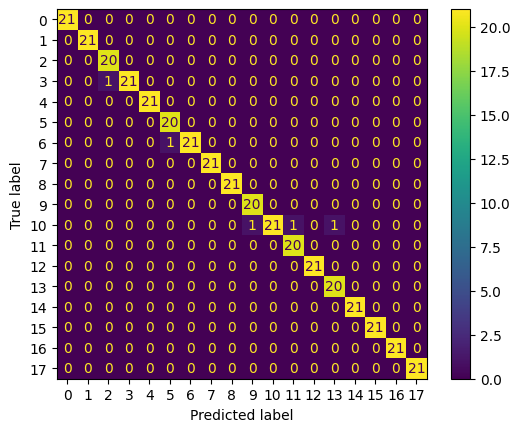

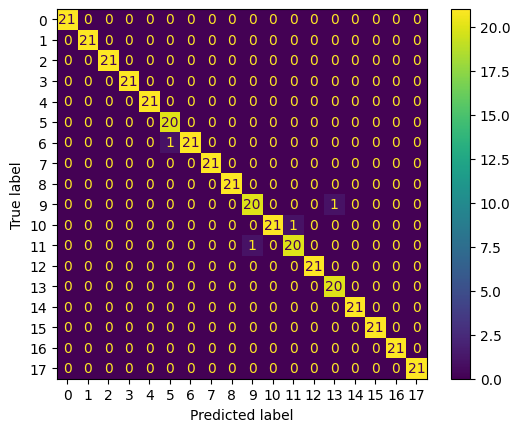

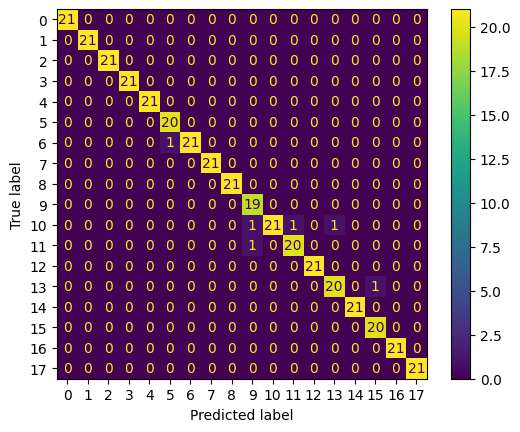

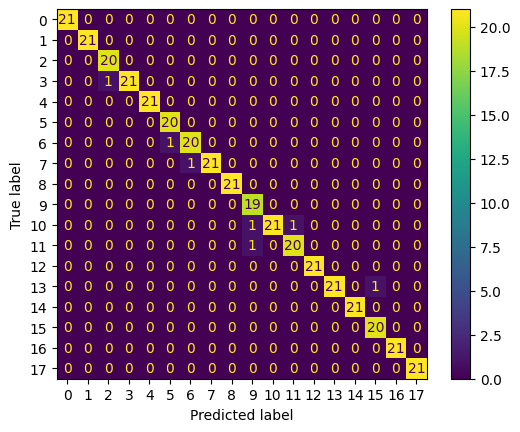

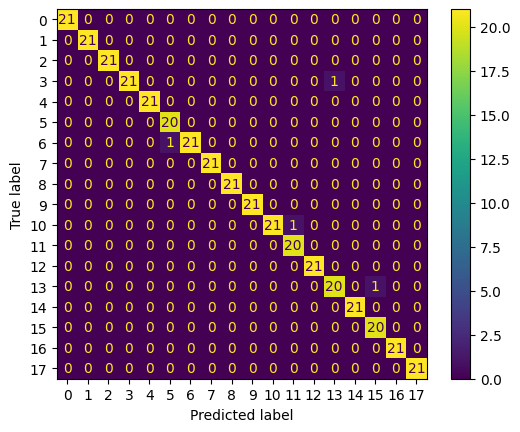

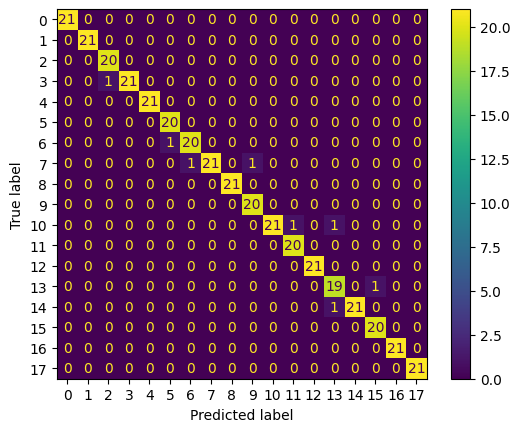

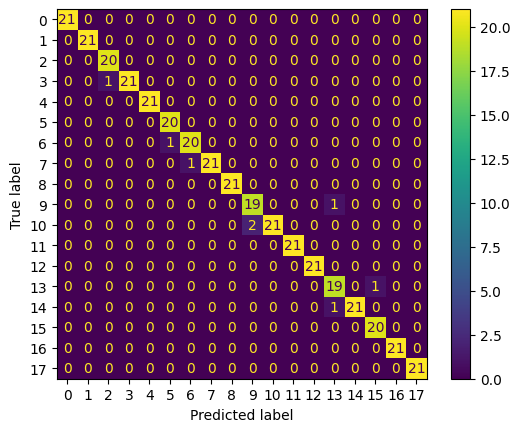

Mean accuracy (10 runs): 0.9828. Mean f1-score: 0.9827.Std accuracy (10 runs): 0.0041. Std f1-score: 0.0041


In [129]:
experiment = SimpleTrainEvalWorkflow(
    estimator=RandomForestClassifier,
    do_not_instantiate=False,
    do_fit=True,
    evaluator=reporter,
)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=10, debug=False)
results = multi_run_experiment(train, [test])

mean_acc = np.average(
    [res["result"][0]["accuracy"] for res in results["runs"]]
)

std_acc = np.std(
    [res["result"][0]["accuracy"] for res in results["runs"]]
)

mean_f1 = np.average(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)
std_f1 = np.std(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)

print(f"Mean accuracy (10 runs): {mean_acc:.4f}. Mean f1-score: {mean_f1:.4f}.Std accuracy (10 runs): {std_acc:.4f}. Std f1-score: {std_f1:.4f}")

### SVM

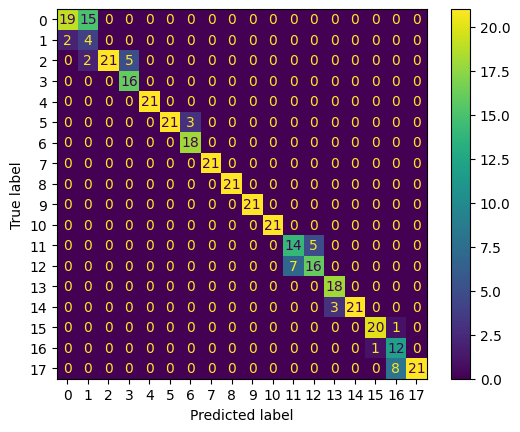

Mean accuracy (1 runs): 0.8624. Mean f1-score: 0.8722.Std accuracy (1 runs): 0.0000. Std f1-score: 0.0000


In [130]:
experiment = SimpleTrainEvalWorkflow(
    estimator=SVC,
    do_not_instantiate=False,
    do_fit=True,
    evaluator=reporter,
)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=1, debug=False)
results = multi_run_experiment(train, [test])

mean_acc = np.average(
    [res["result"][0]["accuracy"] for res in results["runs"]]
)

std_acc = np.std(
    [res["result"][0]["accuracy"] for res in results["runs"]]
)

mean_f1 = np.average(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)
std_f1 = np.std(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)

print(f"Mean accuracy (1 runs): {mean_acc:.4f}. Mean f1-score: {mean_f1:.4f}.Std accuracy (1 runs): {std_acc:.4f}. Std f1-score: {std_f1:.4f}")

### KNN

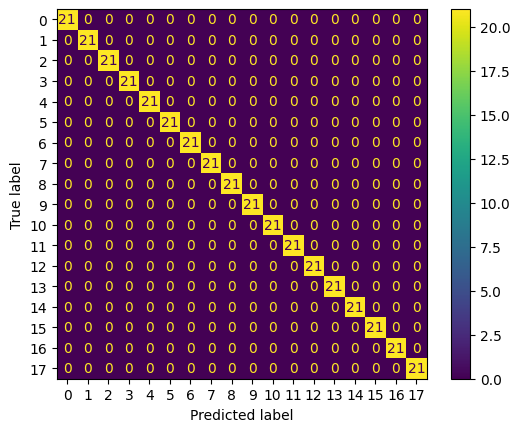

Mean accuracy (1 runs): 1.0000. Mean f1-score: 1.0000.Std accuracy (1 runs): 0.0000. Std f1-score: 0.0000


In [131]:
experiment = SimpleTrainEvalWorkflow(
    estimator=KNeighborsClassifier,
    do_not_instantiate=False,
    do_fit=True,
    evaluator=reporter,
)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=1, debug=False)
results = multi_run_experiment(train, [test])

mean_acc = np.average(
    [res["result"][0]["accuracy"] for res in results["runs"]]
)

std_acc = np.std(
    [res["result"][0]["accuracy"] for res in results["runs"]]
)

mean_f1 = np.average(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)
std_f1 = np.std(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)

print(f"Mean accuracy (1 runs): {mean_acc:.4f}. Mean f1-score: {mean_f1:.4f}.Std accuracy (1 runs): {std_acc:.4f}. Std f1-score: {std_f1:.4f}")

## Plot UMAP and T-SNE

In [45]:
# def plot(df, figsize: tuple = (5, 5), title: str = None, labels: dict = None):
#     fig, ax = plt.subplots(figsize=figsize)
#     for label, group_df in df.groupby("label"):
#         label = labels[label] if labels is not None else label
#         ax.scatter(group_df.x, group_df.y, label=label)
#     ax.legend()
#     plt.title(title)
#     plt.show()

In [46]:
# labels = {0: "Sitting in a Chair", 1: "Sitting in a Couch", 2: "Standing", 3: "Lying up", 4: "Lying side", 5: "Device on surface",
# 6: "Walking", 7: "Running", 8: "Walking Upstairs", 9: "Walking Downstairs"}
# print(labels)

In [47]:
# labels = {'K': 'KuHar', 
#           'M': 'MotionSense',
#           'C': 'CHARM',
#           'E': 'ExtraSensory',
#           'W': 'WISDM',
#           'U': 'UCI',
#          }

# # KuHAR	K
# # MotionSense	M
# # CHARM	C
# # ExtraSensory	E
# # WISDM	W
# # UCI	U

### UMAP

In [48]:
# model = UMAP(n_components=2, random_state=42)
# result = pd.DataFrame(model.fit_transform(train_universal_fft[:][0]), columns=["x", "y"])
# result["label"] = train_universal_fft[:][1]
# plot(result, title="UMAP on ExtraSensory, UCI-HAR, and WISDM FFT data", labels = labels)

In [49]:
# # model = UMAP(n_components=2)
# result = pd.DataFrame(model.transform(test_fft[:][0]), columns=["x", "y"])
# result["label"] = test_fft[:][1]
# plot(result, title="UMAP projection on KuHar, MotionSense, and CHARM FFT data", labels = labels)

### T-SNE

In [50]:
# model = TSNE(n_components=2, random_state=42)
# result = pd.DataFrame(model.fit_transform(train_universal[:][0]), columns=["x", "y"])
# result["label"] = train_universal[:][1]
# plot(result, title="T-SNE on ExtraSensory, UCI-HAR, and WISDM FFT data", labels=labels)